# HIV Methylation Age: Model Comparison

In [12]:
import NotebookImport
from Age_Models_All_Patients import *

In [13]:
groups = (duration.str.startswith('HIV')).combine_first(labels)
groups = groups.ix[groups != 's2']

In [14]:
k = ti((age < 68) & (age > 25))
k = k.difference(ti((labels == 's2') & (gender == 'F')))
k = k.difference(ti(duration != 'Control')).difference(ti(labels=='s2').difference(duration.index))

In [15]:
m1_adj, m2_adj, mc_adj = two_step_adjustment(pred, pred_horvath, age, labels.ix[k])
m1_adj.name = 'Hannum model'
m2_adj.name = 'Horvath model'

In [16]:
from Setup.Imports import *

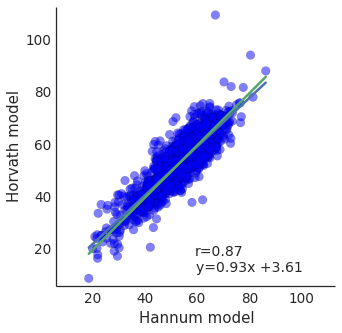

In [17]:
#Do not import
plot_regression(m1_adj, m2_adj)

In [ ]:
diff = ((m1_adj - m2_adj) / ((m1_adj + m2_adj) * .5)).abs()

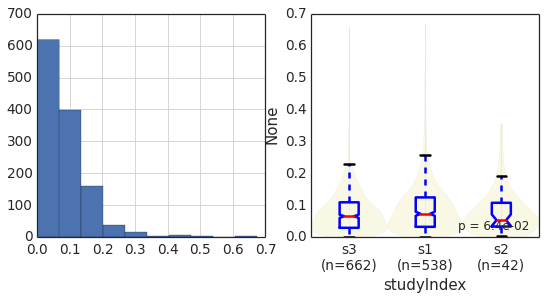

In [18]:
#Do not import
fig, axs = subplots(1,2, figsize=(9,4))
diff.hist(ax=axs[0])
violin_plot_pandas(labels, diff, ax=axs[1])

In [19]:
from Setup.MethylationAgeModels import hannum_model, horvath_model

It seems that the majority of patients for which the models disagree significantly are enriched for having model probes with poor detection quality. This kind of makes sense. 

In [20]:
detection_p = pd.read_hdf(HDFS_DIR + 'dx_methylation.h5', 'detection_p')
#detection_p = detection_p[detection_p[0] > 10e-5]
detection_p = detection_p[detection_p.Sample_Name.isin(diff.index)]
in_model = detection_p[detection_p.level_0.isin(hannum_model.index.union(horvath_model.index))]

In [21]:
v = in_model.groupby('Sample_Name').size().ix[diff.index].fillna(0)
fisher_exact_test(diff > .2, v > 0)

odds_ratio    3.91e+00
p             2.17e-04
dtype: float64

In [22]:
o = ti(diff > .2)
len(o)

68

In [23]:
pts = ti(diff < .2)
m1_adj_c, m2_adj_c, mc_adj_c = two_step_adjustment(pred, pred_horvath, age, labels.ix[pts])
mc_adj_c.name = 'Consensus Model'

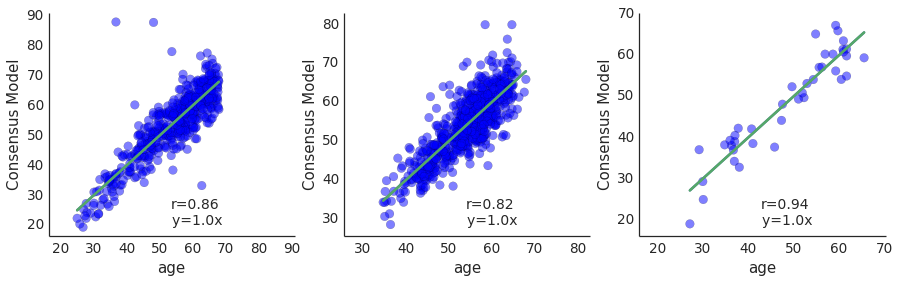

In [24]:
#Do not import
fig, axs = subplots(1,3, figsize=(15,4))

plot_regression(age.ix[ti(labels == 's1')], mc_adj_c, ax=axs[0])
plot_regression(age.ix[ti(labels == 's3')], mc_adj_c, ax=axs[1])
plot_regression(age.ix[ti(labels == 's2')], mc_adj_c, ax=axs[2])

In [25]:
dd = pd.DataFrame({(s, m.name): model_fit(m.ix[ti(l2 == s)], age) 
                   for s in l2.unique()
                   for m in [m1_adj, m2_adj, mc_adj, mc_adj_c]})
dd = dd.unstack().unstack(1).T
dd

EPIC                             Hannum                             Primary Cohort                            
                            n     r error (years) % error      n     r error (years) % error              n     r error (years) % error
Consensus Model           637  0.82          3.65    6.79    497  0.86          4.06    7.81             40  0.94          3.30    7.60
Hannum model              662  0.82          3.69    6.88    538  0.87          4.19    8.33             42  0.92          3.77    8.79
Horvath model             662  0.75          4.64    8.79    538  0.82          5.14   10.07             42  0.91          3.74    8.76
Predicted Age (Combined)  662  0.82          3.69    6.89    538  0.87          4.12    8.06             42  0.93          3.49    8.27

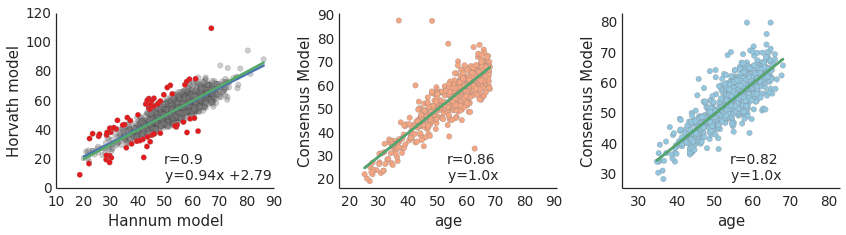

In [26]:
#Do not import 
fig, axs = subplots(1,3, figsize=(12,3.5))
ax = axs[0]
plot_regression(m1_adj, m2_adj.ix[ti(diff < .2)], ax=ax, s=30,
                 color='grey', edgecolor='black', alpha=.4)
series_scatter(m1_adj, m2_adj.ix[ti(diff > .2)], color=colors[0], 
               ax=ax, alpha=1, edgecolor='grey', ann=None,
               s=30)
plot_regression(age.ix[ti(labels == 's1')], mc_adj_c, ax=axs[1],
                s=30, color=colors_st[1], alpha=1, edgecolor='grey')
plot_regression(age.ix[ti(labels == 's3')], mc_adj_c, ax=axs[2],
                s=30, color=colors_st[2], alpha=1, edgecolor='grey')
fig.tight_layout()


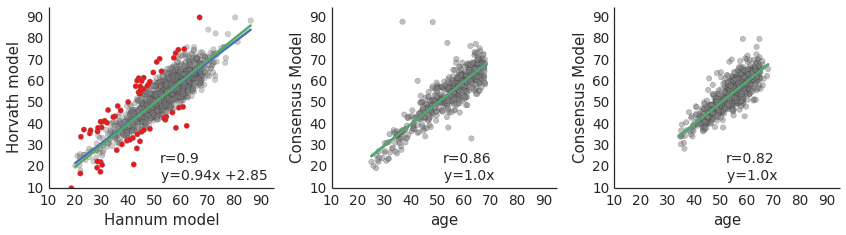

In [27]:
#Do not import
fig, axs = subplots(1,3, figsize=(12,3.5))
ax = axs[0]

plot_regression(m1_adj.clip(10, 90), m2_adj.clip(10, 90).ix[ti(diff < .2)], ax=ax, s=30,
                 color='grey', edgecolor='black', alpha=.4)
series_scatter(m1_adj.clip(10, 90), m2_adj.clip(10, 90).ix[ti(diff >= .2)], color=colors[0], 
               ax=ax, alpha=1, edgecolor='grey', ann=None,
               s=30)
plot_regression(age.ix[ti(labels == 's1')], mc_adj_c, ax=axs[1],
                s=30, color='grey', edgecolor='black')
plot_regression(age.ix[ti(labels == 's3')], mc_adj_c, ax=axs[2],
                s=30, color='grey', edgecolor='black')
for ax in axs:
    ax.set_xlim(10,95)
    ax.set_ylim(10,95)
    
fig.tight_layout()
fig.savefig(FIGDIR + 'f2_top.pdf')